# Implementation of Regression and Tree Decision Models

In order to get a models that enables us to predict sales given the features two models were implemented: 
- **Linear Regression**
    - $R²$ Score: 0.5564
    - Average Error (RMSE): 1142.0976 USD
- **Decision Tree Classifier** 
    - $R²$ Score: 0.5852
    - Average Error (RMSE): 1104.4446 USD

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("food_sales_forecast_cleaned.csv")
df.head()

,Outlet_Location_Type,Outlet_Type,Outlet_Identifier,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Item_Outlet_Sales
0,Tier 1,Grocery Store,OUT019,DRA24,Regular,0.069909,Soft Drinks,163.2868,Small,491.3604
1,Tier 1,Grocery Store,OUT019,DRA59,Regular,0.223985,Soft Drinks,186.2924,Small,555.2772
2,Tier 1,Grocery Store,OUT019,DRC25,Low Fat,0.079440,Soft Drinks,86.7882,Small,85.8882
3,Tier 1,Grocery Store,OUT019,DRD15,Low Fat,0.099442,Dairy,233.1642,Small,697.0926
4,Tier 1,Grocery Store,OUT019,DRD25,Low Fat,0.138270,Soft Drinks,111.6860,Small,452.7440


## Splitting the Dataset 

In [3]:
X = df.drop(columns=["Item_Outlet_Sales", "Item_Identifier"])
y = df["Item_Outlet_Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
num_features = make_column_selector(dtype_include="number")(X)
cat_features = make_column_selector(dtype_include="object")(X)
print(f"Numerical columns: {num_features} \nCategorical columns: {cat_features}")
#print(f"Nominal features: {features[0]} \nCategorical features: {features[1]}")

Numerical columns: ['Item_Visibility', 'Item_MRP'] 
Categorical columns: ['Outlet_Location_Type', 'Outlet_Type', 'Outlet_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Size']


In this case we can observe that the all the **ordinal features** are as follow:
- Item_Fat_content
- Outlet_Size

The **nominal features** are the following:
- Item_Identifier --> This column will be deleted because it has more that 1000 categories and it is possible to do the analysis without the column.
- Item_Type
- Outlet_Identifier
- Outlet_Location_Type
- Outlet_Type

## Instantiate Transformers

In [6]:
ordinal_encoder = OrdinalEncoder()
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

## Instantiate Pipelines

In [7]:
num_pipe = make_pipeline(scaler)
ord_cat_pipe = make_pipeline(ordinal_encoder)
nom_cat_pipe = make_pipeline(ohe)

In [8]:
num_tuple = (num_pipe, ['Item_Visibility', 'Item_MRP'])
ord_tuple = (ord_cat_pipe, ["Item_Fat_Content", "Outlet_Size"])
nom_tuple = (nom_cat_pipe, ["Item_Type", "Outlet_Identifier", "Outlet_Location_Type", "Outlet_Type"])

## Instantiate ColumnTransformer

In [10]:
preprocessor = make_column_transformer(num_tuple, ord_tuple, nom_tuple)
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['Item_Visibility', 'Item_MRP']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['Item_Fat_Content', 'Outlet_Size']),
                                ('pipeline-3',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Item_Type', 'Outlet_Identifier',
                                  'Outlet_Location_Type', 'Outlet_Type'])])

In [11]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Models

## Linear regression

In [12]:
reg = LinearRegression() # to instantiate the class
reg.fit(X_train_processed, y_train) # stimate the parameters

LinearRegression()

In [13]:
reg.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

### Regression predictions

In [18]:
reg_test_predictions = reg.predict(X_test_processed)

print(f"Prediction {reg_test_predictions[:20].tolist()}")
print(f"\nActual {y_test[:20].tolist()}")

Prediction [2092.0, 2006.0, 2256.0, 2396.0, 4136.0, 3372.0, 2928.0, 1864.0, -428.0, 3092.0, 1512.0, 2730.0, 3590.0, 1388.0, 836.0, 3200.0, -12.0, 1532.0, 4800.0, 2744.0]

Actual [1177.1344, 3552.7088, 1662.5026, 3611.2992, 4207.856, 8323.8316, 2328.3026, 1969.4364, 186.424, 2876.256, 1076.5986, 5077.3908, 2055.3246, 856.8846, 172.4422, 5084.0488, 487.3656, 930.1226, 6964.9338, 4813.734]


There are predictions below zero which does not make sense. It seem that the performance of this model will not be so good. Let's evaluate the model.

### $R²$ Linear Regression

In [19]:
reg_train_score = reg.score(X_train_processed, y_train)
reg_test_score = reg.score(X_test_processed, y_test)
print(f"Train Score: {reg_train_score}")
print(f"Test Score: {reg_test_score}")

Train Score: 0.5657800090786036
Test Score: 0.5564388562864708


Having seen the scores in both training ad test data sets it can be said that the model **does not present overfitting, but it does not explain so good the relationship among the features and the label** which was to be expected since the characteristics were not correlated. Let's check the root of the mean square error.

### Mean Square Error Linear regression

In [24]:
train_pred = reg.predict(X_train_processed)
test_pred = reg.predict(X_test_processed)

In [25]:
mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)
print(f"Training Score: {mse_train}")
print(f"Testing Score: {mse_test}")

Training Score: 1260169.7130376247
Testing Score: 1304386.9835676693


In [26]:
print(f"Training Score: {np.sqrt(mse_train)}", f"\nTesting Score {np.sqrt(mse_test)}")

Training Score: 1122.572809682127 
Testing Score 1142.0976243595244


Given the scores it can be said that in average the error in the prediction is $\pm$ 1142.10 dollars in the sales prediction, given the test data set. 

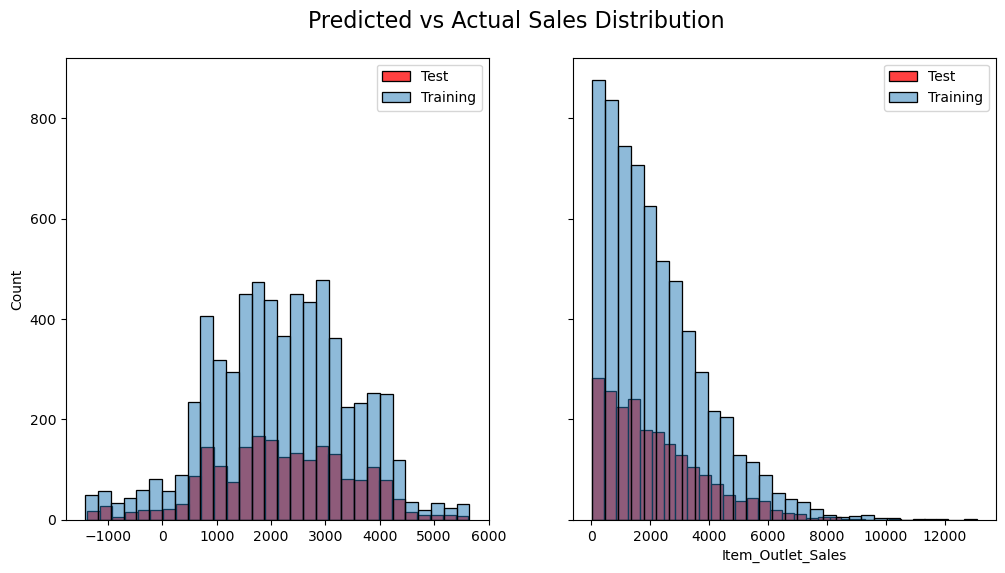

In [68]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(12,6))
sns.histplot(test_pred, color="red", bins=30, ax=ax1)
sns.histplot(train_pred, bins=30, alpha=0.5, ax=ax1)
sns.histplot(y_test, bins=30, ax=ax2, color="red")
sns.histplot(y_train, bins=30, ax=ax2, alpha=0.5)
#plt.xlim(0, 6500)
ax1.legend(labels=["Test", "Training"])
ax2.legend(labels=["Test", "Training"])
plt.suptitle("Predicted vs Actual Sales Distribution", y=0.96, fontsize=16)
plt.show()

## Regression Tree

In [28]:
dec_tree = DecisionTreeRegressor(random_state=42)
dec_tree.fit(X_train_processed, y_train)

DecisionTreeRegressor(random_state=42)

In [29]:
tree_train_pred = dec_tree.predict(X_train_processed)
tree_test_pred = dec_tree.predict(X_test_processed)
print(f"Test Prediction {tree_test_pred[:20].tolist()}")
print(f"\nActual Test {y_test[:20].tolist()}")

Test Prediction [2982.784, 367.5216, 1662.5026, 2871.5954, 2878.2534, 2900.2248, 3067.3406, 1621.8888, 189.0872, 1701.7848, 2094.6068, 1304.968, 4725.8484, 934.7832, 174.4396, 2387.5588, 121.1756, 610.5386, 8958.339, 2406.867]

Actual Test [1177.1344, 3552.7088, 1662.5026, 3611.2992, 4207.856, 8323.8316, 2328.3026, 1969.4364, 186.424, 2876.256, 1076.5986, 5077.3908, 2055.3246, 856.8846, 172.4422, 5084.0488, 487.3656, 930.1226, 6964.9338, 4813.734]


In [30]:
tree_r2_train_score = dec_tree.score(X_train_processed, y_train)
tree_r2_test_score = dec_tree.score(X_test_processed, y_test)
print(f"Training Score: {tree_r2_train_score}",f"\nTestting Score: {tree_r2_test_score}")

Training Score: 1.0 
Testting Score: 0.22132827141710942


We see that the model presents **overfitting**, so let's modify the hyperparameters. 

In [49]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

Let's get the depth to see the prove the performance with different depths. 

In [50]:
dec_tree.get_depth()

39

In [51]:
max_depth_range = list(range(2, 39))
r2 = []

for depth in max_depth_range:
    tree = DecisionTreeRegressor(max_depth=depth,
                                random_state=42)
    tree.fit(X_train_processed, y_train)
    r2.append(tree.score(X_test_processed, y_test))

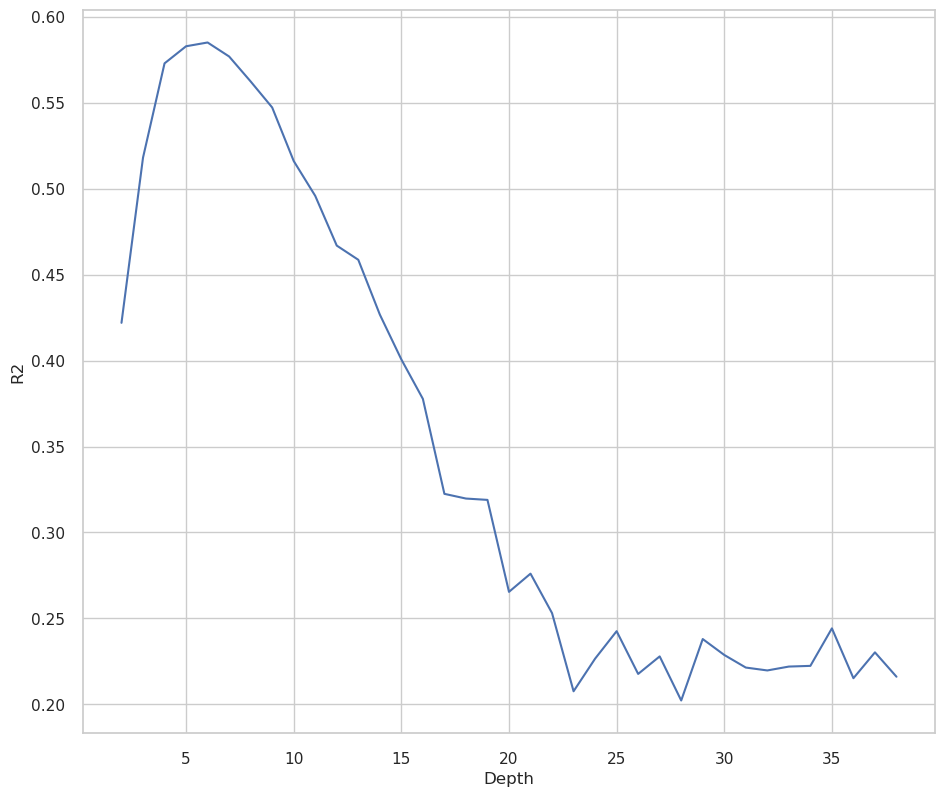

In [52]:
plt.plot(max_depth_range, r2)
plt.xlabel("Depth")
plt.ylabel("R2")
plt.show()

Getting the scores in the test data set we see that the model presents a better performance when the depth has a vaue of six, so let's use that value in the model.

### $R²$ Decision Tree Regressor

In [34]:
tree_depth_6 = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_depth_6.fit(X_train_processed, y_train)
print(f"Training Score: {tree_depth_6.score(X_train_processed, y_train)}",
     f"Testing Score: {tree_depth_6.score(X_test_processed, y_test)}")

Training Score: 0.6177652319981206 Testing Score: 0.5852036194426379


In this case we have get a better score in the testing data set. Let's check the root of the mean square error.

### RMSE 

In [35]:
train_pred_dtree = tree_depth_6.predict(X_train_processed)
test_pred_dtree = tree_depth_6.predict(X_test_processed)

In [36]:
mse_train_dtree = mean_squared_error(y_train, train_pred_dtree)
mse_test_dtree = mean_squared_error(y_test, test_pred_dtree)
print(f"Training Score: {mse_train_dtree}")
print(f"Testing Score: {mse_test_dtree}")

Training Score: 1109301.0178638375
Testing Score: 1219798.008230047


In [37]:
print(f"Training Score: {np.sqrt(mse_train_dtree)}", f"\nTesting Score {np.sqrt(mse_test_dtree)}")

Training Score: 1053.2336008046066 
Testing Score 1104.4446605557234


Given the scores it can be said that in average the error in the prediction is $\pm$ 1104.44 dollars in the sales prediction, given the test data set. Which is less compare to the regression model.

## Sales Distribution

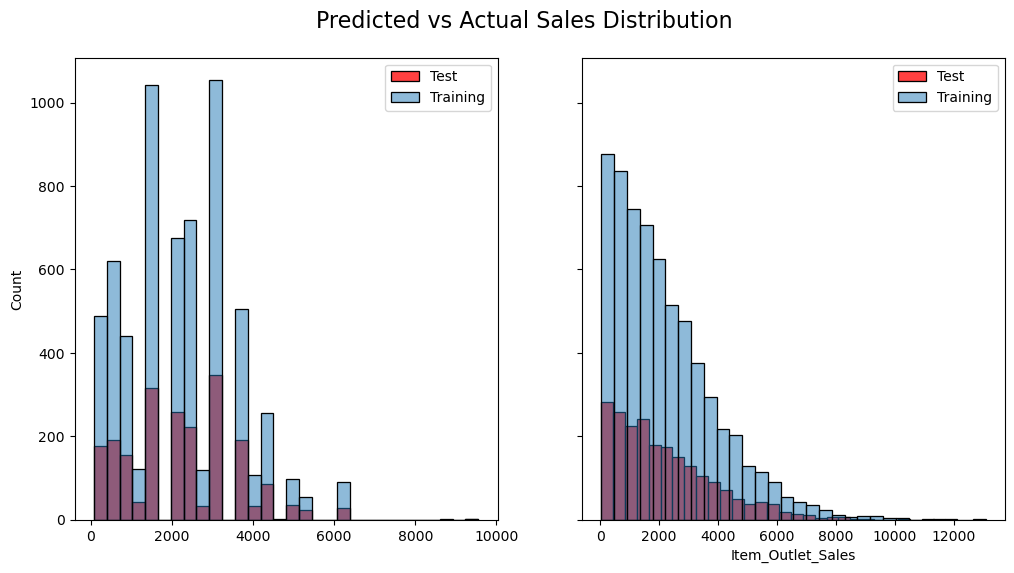

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(12,6))
sns.histplot(test_pred_dtree, color="red", bins=30, ax=ax1)
sns.histplot(train_pred_dtree, bins=30, alpha=0.5, ax=ax1)
sns.histplot(y_test, bins=30, ax=ax2, color="red")
sns.histplot(y_train, bins=30, ax=ax2, alpha=0.5)
#plt.xlim(0, 6500)
ax1.legend(labels=["Test", "Training"])
ax2.legend(labels=["Test", "Training"])
plt.suptitle("Predicted vs Actual Sales Distribution", y=0.96, fontsize=16)
plt.show()

# Model Selection

Given the results, the model that best fits the real data is the Regression Tree, obtaining a score of 58% on the test data set. Although the intended distribution is quite different from the actual one, this is the best option so far.